#Keras 구글 GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [ ]:
import pandas as pd

# Read the dataset
#dataset_path = '5년 데이터.csv' 단순경로
dataset_path = '/content/drive/MyDrive/AICP 연습/0820_5y_data_FINISH.csv' #구글 GPU경로
#dataset_path = '/content/drive/MyDrive/AICP/5년 데이터.csv'
data = pd.read_csv(dataset_path)

In [ ]:
# Extract the 'Name' column
names = data['Name']

# Drop 'Pcr', 'Stock', and 'Name' columns for calculations
new_data = data.drop(columns=['Pcr', 'Stock', 'Name'])

In [ ]:
print("data의 모양:", data.shape)

data의 모양: (11132, 17)


In [ ]:
new_data

,종가,시가,고가,저가,대용가,거래량,거래대금,PER,PSR,PBR,PCR,P/EBITDAPS,Dividend Yield,Volatility
0,105000,106000,106500,104500,84400,218944,23101434310,13.60,4.42,2.03,12.03,9.85,3.50,21.82
1,16250,16300,16400,16000,12670,2034897,32912588400,12.44,0.58,1.63,3.11,2.81,2.46,32.43
2,96000,96200,96700,95500,74880,78276,7516634400,1.07,0.16,0.07,0.74,0.60,8.03,29.03
3,38700,38300,38850,37750,28860,54615,2102557700,15.58,1.11,1.04,19.04,9.35,0.81,36.49
4,1180000,1198000,1199000,1175000,926640,33323,39357577000,33.20,5.23,9.46,26.64,26.14,0.72,33.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127,71100,71300,72200,71000,54490,168687,12042269200,1.86,0.12,0.19,5.10,2.43,2.70,30.73
11128,39650,38650,40100,38600,30490,226682,8977016350,18.36,1.39,1.00,17.91,35.51,1.99,33.45
11129,122400,121000,125400,121000,94010,89322,10936741500,46.22,5.15,5.27,36.17,26.01,0.78,31.43
11130,106900,105000,106900,103700,79870,16374,1737368100,43.63,0.33,0.51,14.20,4.53,2.02,21.87


#GPU 적용

In [ ]:
import pandas as pd
import numpy as np
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

# 100번 반복
num_iterations = 100
results = []

with tf.device('/device:GPU:0'):
  for _ in range(num_iterations):

    # Normalize the data
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(new_data)

    # Split the data into train and test sets
    train_data = data_normalized[:8800]
    test_data = data_normalized[8800:]

    # Define the dimensions of the autoencoder
    input_dim = train_data.shape[1]
    encoding_dim = 32

    # Define the autoencoder architecture
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    # Create the autoencoder model
    autoencoder = Model(input_layer, decoded)

    # Compile the autoencoder model with 'adam' optimizer
    optimizer = Adam(learning_rate=0.0001)
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the autoencoder on the train data
    autoencoder.fit(train_data, train_data, epochs= 100, batch_size= 32, shuffle=True)

    # Get the encoded representations of the test data
    encoded_test_data = autoencoder.predict(test_data)

    # Convert the encoded test data back to DataFrame format
    encoded_test_df = pd.DataFrame(encoded_test_data, columns=new_data.columns)

    # Calculate the predicted values by passing encoded test data through decoder
    predicted_test_data = autoencoder.predict(encoded_test_data)

    # Convert the predicted_test_data array back to a DataFrame with column names
    predicted_test_df = pd.DataFrame(predicted_test_data, columns=new_data.columns)

    # Add the 'Predicted_Price' column to the predicted_df
    predicted_test_df['Predicted_Price'] = predicted_test_data[:, 0]  # Extracting the first column of predicted_data

    # Convert test_data to df
    test_data_df = pd.DataFrame(test_data, columns=new_data.columns)
    test_data_df

    # Calculate the differences between predicted and real values
    predicted_test_df['Difference'] = np.abs(predicted_test_df['Predicted_Price'] - test_data_df['종가'])

    # Concatenate the 'names' Series with the predicted_df DataFrame
    result_df = pd.concat([names, predicted_test_df], axis=1)

    # Add the names to the result DataFrame
    result_df['실제 종가'] = test_data_df['종가']

    # Find the top and bottom records
    top_records = result_df.nsmallest(253, 'Difference')
    bottom_records = result_df.nlargest(253, 'Difference')

    # Extract the names of top and bottom records
    top_names = names.loc[top_records.index].reset_index(drop=True)
    bottom_names = names.loc[bottom_records.index].reset_index(drop=True)

    # Add the names to the result DataFrame
    result_df['Top_15_Name'] = top_names[:253]
    result_df['Bottom_15_Name'] = bottom_names[:253]

    # Select the relevant columns from the result DataFrame
    result_df = result_df.dropna(subset=['Top_15_Name', 'Bottom_15_Name', '실제 종가'])

    # Reset the index of top_records
    top_records_reset = top_records.reset_index(drop=True)

    # Extract the relevant columns from top_records
    top_records_selected = top_records_reset[['Predicted_Price', '실제 종가', 'Difference']]

    # Concatenate top_names and top_records_selected
    top_result_df = pd.concat([top_names, top_records_selected], axis=1)
    top_result_df.rename(columns={'Name': 'Top Name'}, inplace=True)

    # Reset the index of bottom_records
    bottom_records_reset = bottom_records.reset_index(drop=True)

    # Extract the relevant columns from bottom_records
    bottom_records_selected = bottom_records_reset[['Predicted_Price', '실제 종가', 'Difference']]

    # Concatenate bottom_names and bottom_records_selected
    bottom_result_df = pd.concat([bottom_names, bottom_records_selected], axis=1)
    bottom_result_df.rename(columns={'Name': 'Bottom Name'}, inplace=True)

    total_df = pd.concat([top_result_df, bottom_result_df], axis=1)
    results.append(total_df)

  for i, result in enumerate(results):
    print(f"Iteration {i + 1} results:")
    print(result)

#total_df

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 12/100
275/275 [==============================] - 1s 3ms/step - loss: 0.5673
Epoch 13/100
275/275 [==============================] - 1s 3ms/step - loss: 0.5608
Epoch 14/100
275/275 [==============================] - 1s 3ms/step - loss: 0.5556
Epoch 15/100
275/275 [==============================] - 1s 3ms/step - loss: 0.5513
Epoch 16/100
275/275 [==============================] - 1s 3ms/step - loss: 0.5477
Epoch 17/100
275/275 [==============================] - 1s 3ms/step - loss: 0.5447
Epoch 18/100
275/275 [==============================] - 1s 3ms/step - loss: 0.5421
Epoch 19/100
275/275 [==============================] - 1s 3ms/step - loss: 0.5400
Epoch 20/100
275/275 [==============================] - 1s 3ms/step - loss: 0.5381
Epoch 21/100
275/275 [==============================] - 1s 3ms/step - loss: 0.5365
Epoch 22/100
275/275 [==============================] - 1s 3ms/step - loss: 0.5351
Epoch 23/100
275/275 [=============================

In [ ]:
results

[      Top Name  Predicted_Price     실제 종가  Difference Bottom Name  \
 0     현대모비스(주)         0.342542  0.342633    0.000090   (주)LG생활건강   
 1     (주)한솔케미칼         0.079460  0.079657    0.000197   (주)LG생활건강   
 2    금호석유화학(주)         0.036375  0.035984    0.000391   (주)LG생활건강   
 3     (주)한솔케미칼         0.258527  0.258105    0.000422   (주)LG생활건강   
 4      (주)셀트리온         0.140098  0.140705    0.000607   (주)LG생활건강   
 ..         ...              ...       ...         ...         ...   
 248   엘지이노텍(주)         0.946274  0.981289    0.035015     (주)제일기획   
 249     (주)신세계         0.279083  0.314457    0.035374       (주)동서   
 250   현대자동차(주)         0.135711  0.171229    0.035518     (주)제일기획   
 251    (주)셀트리온         0.033855 -0.002054    0.035909     (주)제일기획   
 252     (주)신세계         0.215137  0.251061    0.035924  티케이지휴켐스(주)   
 
      Predicted_Price     실제 종가  Difference  
 0           0.967044  2.934824    1.967780  
 1           0.965706  2.850296    1.884590  
 2           0.96578

In [ ]:
# results 리스트 안에 있는 모든 total_df를 연결하여 하나의 데이터프레임으로 만듦
combined_df = pd.concat(results, ignore_index=True)

# combined_df를 출력하거나 처리
combined_df

,Top Name,Predicted_Price,실제 종가,Difference,Bottom Name,Predicted_Price,실제 종가,Difference
0,현대모비스(주),0.342542,0.342633,0.000090,(주)LG생활건강,0.967044,2.934824,1.967780
1,(주)한솔케미칼,0.079460,0.079657,0.000197,(주)LG생활건강,0.965706,2.850296,1.884590
2,금호석유화학(주),0.036375,0.035984,0.000391,(주)LG생활건강,0.965787,2.840904,1.875117
3,(주)한솔케미칼,0.258527,0.258105,0.000422,(주)LG생활건강,0.965626,2.817424,1.851798
4,(주)셀트리온,0.140098,0.140705,0.000607,(주)LG생활건강,0.964883,2.770464,1.805581
...,...,...,...,...,...,...,...,...
25295,(주)녹십자,0.107686,0.058525,0.049161,(주)제일기획,0.031743,-0.633431,0.665173
25296,(주)신세계,0.396492,0.347329,0.049163,(주)동서,0.030986,-0.634135,0.665121
25297,(주)한솔케미칼,0.368480,0.319153,0.049328,티케이지휴켐스(주),0.035201,-0.629909,0.665109
25298,(주)엔씨소프트,0.954551,1.004769,0.050218,티케이지휴켐스(주),0.034871,-0.630143,0.665014


In [ ]:
combined_df['Top Name'].value_counts()

현대글로비스(주)     5003
현대자동차(주)      4356
현대모비스(주)      3586
(주)셀트리온       3247
(주)신세계        2251
(주)한솔케미칼      2112
(주)녹십자        1043
(주)농심          952
(주)엔씨소프트       946
엘지이노텍(주)       909
금호석유화학(주)      603
(주)오뚜기         146
(주)아모레퍼시픽       86
(주)오리온          45
삼양식품(주)         11
롯데웰푸드(주)         2
삼성에스디에스(주)       2
Name: Top Name, dtype: int64

In [ ]:
combined_df['Bottom Name'].value_counts()

(주)LG유플러스      5300
(주)LG생활건강      5198
(주)녹십자홀딩스      4888
고려아연(주)        4004
(주)동서          2338
(주)제일기획        1333
티케이지휴켐스(주)      972
(주)현대홈쇼핑        455
(주)셀트리온         351
삼성전자(주)         100
에스케이하이닉스(주)      98
(주)한섬            76
기아(주)            55
(주)농심            46
현대자동차(주)         34
(주)케이티           19
(주)한화            18
(주)영원무역           5
(주)케이티앤지          4
(주)지에스리테일         3
현대글로비스(주)         2
(주)신세계            1
Name: Bottom Name, dtype: int64

Epoch 1/100
314/314 [==============================] - 1s 3ms/step - loss: 1.2174 - val_loss: 0.9432
Epoch 2/100
314/314 [==============================] - 1s 3ms/step - loss: 1.1198 - val_loss: 0.8498
Epoch 3/100
314/314 [==============================] - 1s 3ms/step - loss: 1.0285 - val_loss: 0.7647
Epoch 4/100
314/314 [==============================] - 1s 3ms/step - loss: 0.9479 - val_loss: 0.6886
Epoch 5/100
314/314 [==============================] - 1s 4ms/step - loss: 0.8807 - val_loss: 0.6288
Epoch 6/100
314/314 [==============================] - 1s 4ms/step - loss: 0.8310 - val_loss: 0.5867
Epoch 7/100
314/314 [==============================] - 1s 4ms/step - loss: 0.7969 - val_loss: 0.5585
Epoch 8/100
314/314 [==============================] - 1s 3ms/step - loss: 0.7739 - val_loss: 0.5394
Epoch 9/100
314/314 [==============================] - 1s 3ms/step - loss: 0.7579 - val_loss: 0.5260
Epoch 10/100
314/314 [==============================] - 1s 3ms/step - loss: 0.7464 - val_lo

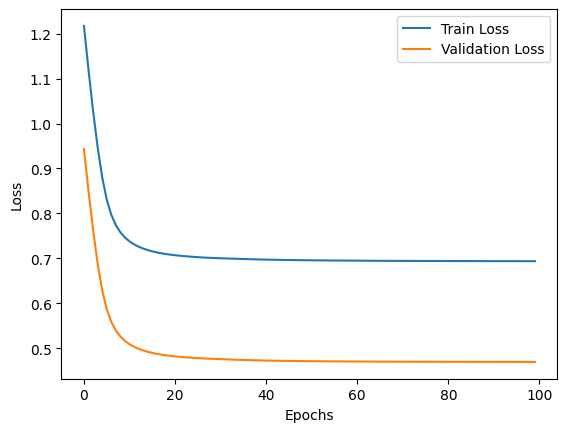

In [ ]:
with tf.device('/device:GPU:0'):

    # 데이터 분할
  train_data, test_data = train_test_split(new_data, test_size=0.1, random_state=42)

  # Normalize the data
  scaler = StandardScaler()
  train_data_normalized = scaler.fit_transform(train_data)
  test_data_normalized = scaler.transform(test_data)

  # Define the dimensions of the autoencoder
  input_dim = train_data_normalized.shape[1]
  encoding_dim = 32

  # Define the autoencoder architecture
  input_layer = Input(shape=(input_dim,))
  encoded = Dense(encoding_dim, activation='relu')(input_layer)
  decoded = Dense(input_dim, activation='sigmoid')(encoded)

  # Create the autoencoder model
  autoencoder = Model(input_layer, decoded)

  # Compile the autoencoder model with 'adam' optimizer
  optimizer = Adam(learning_rate=0.0001)
  autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

  # Train the autoencoder on the train data with validation data
  autoencoder.fit(train_data_normalized, train_data_normalized,
                epochs=100, batch_size=32, shuffle=True,
                validation_data=(test_data_normalized, test_data_normalized))

  # Plot training and validation loss
  import matplotlib.pyplot as plt

  train_loss = autoencoder.history.history['loss']
  val_loss = autoencoder.history.history['val_loss']

  plt.plot(train_loss, label='Train Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()